In [4]:
%pip install imblearn

DEPRECATION: Configuring installation scheme with distutils config files is deprecated and will no longer work in the near future. If you are using a Homebrew or Linuxbrew Python, please see discussion at https://github.com/Homebrew/homebrew-core/issues/76621
    torch (>=1.7.*)
           ~~~~~~^
DEPRECATION: Configuring installation scheme with distutils config files is deprecated and will no longer work in the near future. If you are using a Homebrew or Linuxbrew Python, please see discussion at https://github.com/Homebrew/homebrew-core/issues/76621

[notice] A new release of pip is available: 24.3.1 -> 25.0
[notice] To update, run: python3.9 -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [5]:
# importing libraries
%matplotlib inline
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from scipy.signal import find_peaks
import warnings
warnings.filterwarnings('ignore')
import imblearn

import gausslink

import tqdm
import time


from scipy import signal


In [51]:
# reading raw data file
columns = ['user','activity','timestamp', 'x-axis', 'y-axis', 'z-axis']

In [94]:
har_df = pd.read_csv('./WISDM_ar_v1.1/WISDM_ar_v1.1_raw.txt',names = columns, on_bad_lines='skip')

In [95]:
# removing null values
har_df = har_df.dropna()
har_df.shape

# transforming the z-axis to float
har_df['z-axis'] = har_df['z-axis'].str.replace(';', '')
har_df['z-axis'] = har_df['z-axis'].apply(lambda x:float(x))

# drop the rows where timestamp is 0
df = har_df[har_df['timestamp'] != 0]

# now arrange data in ascending order of the user and timestamp
df = df.sort_values(by = ['user', 'timestamp'], ignore_index=True)

In [55]:
df_test.head()

,user,activity,timestamp,x-axis,y-axis,z-axis
792622,28,Walking,1506362316000,-0.08,7.40,3.173541
792623,28,Walking,1506412243000,-0.04,8.62,2.873893
792624,28,Walking,1506462292000,0.69,9.53,4.181447
792625,28,Walking,1506512249000,-0.76,8.92,4.140586
792626,28,Walking,1506562328000,-1.57,8.58,3.636633


In [96]:
# train data -> Users upto User ID = 27 (i.e. 27 users)
df_train = df[df['user']<28]
# test data -> Users from User ID = 28 to 36 (i.e. 9 users)
df_test = df[df['user']>27]

Downsample Bigger Classes!

In [47]:
df_train['activity'].unique()

array(['Walking', 'Jogging', 'Upstairs', 'Downstairs', 'Sitting',
       'Standing'], dtype=object)

In [97]:
# Statistical Features on raw x, y and z in time domain
X_train = pd.DataFrame()
x_list = []
y_list = []
z_list = []
train_labels = []

window_size = 50 #2s
step_size = 50 #2s
ds=2

In [98]:
user_list = df_train.user.unique()
activity_list = df_train.activity.unique()

In [99]:
for j in user_list:
    for k in activity_list:
        df_sub = df_train.query(f"activity=='{k}'").query(f"user=={j}")
        df_sub=df_sub.reset_index()
        #df_train.query("activity=='Walking'").query("user==1")
        for i in range(0, df_sub.shape[0] - window_size, step_size):
            #print(i)
            xs = df_sub['x-axis'].values[i: i + window_size]
            xs = signal.decimate(xs,ds)
            ys = df_sub['y-axis'].values[i: i + window_size]
            ys = signal.decimate(ys,ds)
            zs = df_sub['z-axis'].values[i: i + window_size]
            zs = signal.decimate(zs,ds)
            label = df_sub['activity'][i: i + window_size][i]

            x_list.append(xs)
            y_list.append(ys)
            z_list.append(zs)
            train_labels.append(label)

In [100]:
len(train_labels)

15790

In [101]:
Xtr = list(zip(x_list, y_list))
len(Xtr)

15790

In [140]:
# creating overlaping windows of size window-size 100

# mean
X_train['x_mean'] = pd.Series(x_list).apply(lambda x: x.mean())
X_train['y_mean'] = pd.Series(y_list).apply(lambda x: x.mean())
X_train['z_mean'] = pd.Series(z_list).apply(lambda x: x.mean())

# argmin 
X_train['x_argmin'] = pd.Series(x_list).apply(lambda x: x.argmin())
X_train['y_argmin'] = pd.Series(y_list).apply(lambda x: x.argmin())
X_train['z_argmin'] = pd.Series(z_list).apply(lambda x: x.argmin())

# std dev
X_train['x_std'] = pd.Series(x_list).apply(lambda x: x.std())
X_train['y_std'] = pd.Series(y_list).apply(lambda x: x.std())
X_train['z_std'] = pd.Series(z_list).apply(lambda x: x.std())

# avg absolute diff
X_train['x_aad'] = pd.Series(x_list).apply(lambda x: np.mean(np.absolute(x - np.mean(x))))
X_train['y_aad'] = pd.Series(y_list).apply(lambda x: np.mean(np.absolute(x - np.mean(x))))
X_train['z_aad'] = pd.Series(z_list).apply(lambda x: np.mean(np.absolute(x - np.mean(x))))

# min
X_train['x_min'] = pd.Series(x_list).apply(lambda x: x.min())
X_train['y_min'] = pd.Series(y_list).apply(lambda x: x.min())
X_train['z_min'] = pd.Series(z_list).apply(lambda x: x.min())

# max
X_train['x_max'] = pd.Series(x_list).apply(lambda x: x.max())
X_train['y_max'] = pd.Series(y_list).apply(lambda x: x.max())
X_train['z_max'] = pd.Series(z_list).apply(lambda x: x.max())

# skewness
X_train['x_skewness'] = pd.Series(x_list).apply(lambda x: stats.skew(x))
X_train['y_skewness'] = pd.Series(y_list).apply(lambda x: stats.skew(x))
X_train['z_skewness'] = pd.Series(z_list).apply(lambda x: stats.skew(x))

#location min ?
X_train['x_skewness'] = pd.Series(x_list).apply(lambda x: stats.skew(x))
X_train['y_skewness'] = pd.Series(y_list).apply(lambda x: stats.skew(x))
X_train['z_skewness'] = pd.Series(z_list).apply(lambda x: stats.skew(x))


In [71]:
y_train = train_labels

In [141]:
wr = []
for i in  tqdm.tqdm(range(len(x_list))):
    xs = x_list[i]
    ys = y_list[i]
    zs = z_list[i]
    xyz = np.array([xs,ys,zs])
    coords = np.swapaxes(xyz,0,1)
    writhe = gausslink.linkage_integral(coords,coords)
    wr.append(writhe)
    
X_train['writhe']=wr


  1%|▎                                      | 123/15790 [00:09<19:57, 13.09it/s]


KeyboardInterrupt: 

In [ ]:
walkingTF = [i for i, string in enumerate(train_labels) if string=='Walking']
joggingTF = [i=='Jogging' for i in train_labels]

In [ ]:
wr_max = []
for i in  tqdm.tqdm(range(len(x_list))):
    xs = x_list[i]
    ys = y_list[i]
    zs = z_list[i]
    xyz = np.array([xs,ys,zs])
    coords = np.swapaxes(xyz,0,1)
    writhe_max = linkage_max(coords,coords)
    wr_max.append(writhe_max)
    
X_train['writhe_max']=wr_max


In [73]:
# converting the signals from time domain to frequency domain using FFT
wds= len(x_list[0])
x_list_fft = pd.Series(x_list).apply(lambda x: np.abs(np.fft.fft(x))[1:wds+1])
y_list_fft = pd.Series(y_list).apply(lambda x: np.abs(np.fft.fft(x))[1:wds+1])
z_list_fft = pd.Series(z_list).apply(lambda x: np.abs(np.fft.fft(x))[1:wds+1])

# Statistical Features on raw x, y and z in frequency domain
# FFT mean
X_train['x_mean_fft'] = pd.Series(x_list_fft).apply(lambda x: x.mean())
X_train['y_mean_fft'] = pd.Series(y_list_fft).apply(lambda x: x.mean())
X_train['z_mean_fft'] = pd.Series(z_list_fft).apply(lambda x: x.mean())

# FFT std dev
X_train['x_std_fft'] = pd.Series(x_list_fft).apply(lambda x: x.std())
X_train['y_std_fft'] = pd.Series(y_list_fft).apply(lambda x: x.std())
X_train['z_std_fft'] = pd.Series(z_list_fft).apply(lambda x: x.std())

# FFT avg absolute diff
X_train['x_aad_fft'] = pd.Series(x_list_fft).apply(lambda x: np.mean(np.absolute(x - np.mean(x))))
X_train['y_aad_fft'] = pd.Series(y_list_fft).apply(lambda x: np.mean(np.absolute(x - np.mean(x))))
X_train['z_aad_fft'] = pd.Series(z_list_fft).apply(lambda x: np.mean(np.absolute(x - np.mean(x))))

# FFT min
X_train['x_min_fft'] = pd.Series(x_list_fft).apply(lambda x: x.min())
X_train['y_min_fft'] = pd.Series(y_list_fft).apply(lambda x: x.min())
X_train['z_min_fft'] = pd.Series(z_list_fft).apply(lambda x: x.min())

# FFT number of peaks
X_train['x_peak_count_fft'] = pd.Series(x_list_fft).apply(lambda x: len(find_peaks(x)[0]))
X_train['y_peak_count_fft'] = pd.Series(y_list_fft).apply(lambda x: len(find_peaks(x)[0]))
X_train['z_peak_count_fft'] = pd.Series(z_list_fft).apply(lambda x: len(find_peaks(x)[0]))

# FFT skewness
X_train['x_skewness_fft'] = pd.Series(x_list_fft).apply(lambda x: stats.skew(x))
X_train['y_skewness_fft'] = pd.Series(y_list_fft).apply(lambda x: stats.skew(x))
X_train['z_skewness_fft'] = pd.Series(z_list_fft).apply(lambda x: stats.skew(x))

# FFT kurtosis
X_train['x_kurtosis_fft'] = pd.Series(x_list_fft).apply(lambda x: stats.kurtosis(x))
X_train['y_kurtosis_fft'] = pd.Series(y_list_fft).apply(lambda x: stats.kurtosis(x))
X_train['z_kurtosis_fft'] = pd.Series(z_list_fft).apply(lambda x: stats.kurtosis(x))

# FFT energy
X_train['x_energy_fft'] = pd.Series(x_list_fft).apply(lambda x: np.sum(x**2)/50)
X_train['y_energy_fft'] = pd.Series(y_list_fft).apply(lambda x: np.sum(x**2)/50)
X_train['z_energy_fft'] = pd.Series(z_list_fft).apply(lambda x: np.sum(x**2/50))

# FFT avg resultant
#X_train['avg_result_accl_fft'] = [i.mean() for i in ((pd.Series(x_list_fft)**2 + pd.Series(y_list_fft)**2 + pd.Series(z_list_fft)**2)**0.5)]

# FFT Signal magnitude area
X_train['sma_fft'] = pd.Series(x_list_fft).apply(lambda x: np.sum(abs(x)/50)) + pd.Series(y_list_fft).apply(lambda x: np.sum(abs(x)/50)) \
                     + pd.Series(z_list_fft).apply(lambda x: np.sum(abs(x)/50))

In [74]:
X_train.to_csv("X_fulltrain_downsampled"+str(window_size)+"_"+str(step_size)+".csv")

### Create test dataframe


In [56]:
# Statistical Features on raw x, y and z in time domain
X_test = pd.DataFrame()

In [57]:
df_test.head()

,user,activity,timestamp,x-axis,y-axis,z-axis
792622,28,Walking,1506362316000,-0.08,7.40,3.173541
792623,28,Walking,1506412243000,-0.04,8.62,2.873893
792624,28,Walking,1506462292000,0.69,9.53,4.181447
792625,28,Walking,1506512249000,-0.76,8.92,4.140586
792626,28,Walking,1506562328000,-1.57,8.58,3.636633


In [86]:
df_test = df_test.drop('level_0',axis=1)

In [77]:
#df_test= df_test.reset_index()
user_list = df_test.user.unique()
x_list = []
y_list = []
z_list = []
test_labels = []

window_size = 50
step_size = 50

for j in user_list:
    for k in activity_list:
        df_sub = df_test.query(f"activity=='{k}'").query(f"user=={j}")
        df_sub=df_sub.reset_index()
        #df_train.query("activity=='Walking'").query("user==1")
        for i in range(0, df_sub.shape[0] - window_size, step_size):
            #print(i)
            xs = df_sub['x-axis'].values[i: i + window_size]
            xs = signal.decimate(xs,ds)
            ys = df_sub['y-axis'].values[i: i + window_size]
            ys = signal.decimate(ys,ds)
            zs = df_sub['z-axis'].values[i: i + window_size]
            zs = signal.decimate(zs,ds)
            label = df_sub['activity'][i: i + window_size][i]

            x_list.append(xs)
            y_list.append(ys)
            z_list.append(zs)
            test_labels.append(label)




In [102]:
len(Xte)

5593

In [78]:
Xte = list(zip(x_list, y_list))

In [58]:
# mean
X_test['x_mean'] = pd.Series(x_list).apply(lambda x: x.mean())
X_test['y_mean'] = pd.Series(y_list).apply(lambda x: x.mean())
X_test['z_mean'] = pd.Series(z_list).apply(lambda x: x.mean())

# argmin 
X_test['x_argmin'] = pd.Series(x_list).apply(lambda x: x.argmin())
X_test['y_argmin'] = pd.Series(y_list).apply(lambda x: x.argmin())
X_test['z_argmin'] = pd.Series(z_list).apply(lambda x: x.argmin())

# std dev
X_test['x_std'] = pd.Series(x_list).apply(lambda x: x.std())
X_test['y_std'] = pd.Series(y_list).apply(lambda x: x.std())
X_test['z_std'] = pd.Series(z_list).apply(lambda x: x.std())

# avg absolute diff
X_test['x_aad'] = pd.Series(x_list).apply(lambda x: np.mean(np.absolute(x - np.mean(x))))
X_test['y_aad'] = pd.Series(y_list).apply(lambda x: np.mean(np.absolute(x - np.mean(x))))
X_test['z_aad'] = pd.Series(z_list).apply(lambda x: np.mean(np.absolute(x - np.mean(x))))

# min
X_test['x_min'] = pd.Series(x_list).apply(lambda x: x.min())
X_test['y_min'] = pd.Series(y_list).apply(lambda x: x.min())
X_test['z_min'] = pd.Series(z_list).apply(lambda x: x.min())

# max
X_test['x_max'] = pd.Series(x_list).apply(lambda x: x.max())
X_test['y_max'] = pd.Series(y_list).apply(lambda x: x.max())
X_test['z_max'] = pd.Series(z_list).apply(lambda x: x.max())

# skewness
X_test['x_skewness'] = pd.Series(x_list).apply(lambda x: stats.skew(x))
X_test['y_skewness'] = pd.Series(y_list).apply(lambda x: stats.skew(x))
X_test['z_skewness'] = pd.Series(z_list).apply(lambda x: stats.skew(x))


In [88]:
wr = []
#wr_max = []
for i in tqdm.tqdm(range(len(x_list))):
    xs = x_list[i]
    ys = y_list[i]
    zs = z_list[i]
    xyz = np.array([xs,ys,zs])
    coords = np.swapaxes(xyz,0,1)
    writhe = gausslink.linkage_integral(coords,coords)
    #writhe_max = linkage_max(coords,coords)
    wr.append(writhe)
    #wr_max.append(writhe_max)

X_test["writhe"]=wr
#X_test['writhe_max']=wr_max

100%|███████████████████████████████████████| 5593/5593 [02:35<00:00, 36.08it/s]


In [89]:
X_train['abs_writhe']=np.abs(X_train["writhe"])
X_test['abs_writhe']=np.abs(X_test["writhe"])

X_train['log_writhe']=np.log10(X_train['abs_writhe'])
X_test['log_writhe']=np.log10(X_test['abs_writhe'])

In [90]:
# converting the signals from time domain to frequency domain using FFT
x_list_fft = pd.Series(x_list).apply(lambda x: np.abs(np.fft.fft(x))[1:wds+1])
y_list_fft = pd.Series(y_list).apply(lambda x: np.abs(np.fft.fft(x))[1:wds+1])
z_list_fft = pd.Series(z_list).apply(lambda x: np.abs(np.fft.fft(x))[1:wds+1])

# Statistical Features on raw x, y and z in frequency domain
# FFT mean
X_test['x_mean_fft'] = pd.Series(x_list_fft).apply(lambda x: x.mean())
X_test['y_mean_fft'] = pd.Series(y_list_fft).apply(lambda x: x.mean())
X_test['z_mean_fft'] = pd.Series(z_list_fft).apply(lambda x: x.mean())

# FFT std dev
X_test['x_std_fft'] = pd.Series(x_list_fft).apply(lambda x: x.std())
X_test['y_std_fft'] = pd.Series(y_list_fft).apply(lambda x: x.std())
X_test['z_std_fft'] = pd.Series(z_list_fft).apply(lambda x: x.std())

# FFT avg absolute diff
X_test['x_aad_fft'] = pd.Series(x_list_fft).apply(lambda x: np.mean(np.absolute(x - np.mean(x))))
X_test['y_aad_fft'] = pd.Series(y_list_fft).apply(lambda x: np.mean(np.absolute(x - np.mean(x))))
X_test['z_aad_fft'] = pd.Series(z_list_fft).apply(lambda x: np.mean(np.absolute(x - np.mean(x))))

# FFT min
X_test['x_min_fft'] = pd.Series(x_list_fft).apply(lambda x: x.min())
X_test['y_min_fft'] = pd.Series(y_list_fft).apply(lambda x: x.min())
X_test['z_min_fft'] = pd.Series(z_list_fft).apply(lambda x: x.min())


# FFT number of peaks
X_test['x_peak_count_fft'] = pd.Series(x_list_fft).apply(lambda x: len(find_peaks(x)[0]))
X_test['y_peak_count_fft'] = pd.Series(y_list_fft).apply(lambda x: len(find_peaks(x)[0]))
X_test['z_peak_count_fft'] = pd.Series(z_list_fft).apply(lambda x: len(find_peaks(x)[0]))

# FFT skewness
X_test['x_skewness_fft'] = pd.Series(x_list_fft).apply(lambda x: stats.skew(x))
X_test['y_skewness_fft'] = pd.Series(y_list_fft).apply(lambda x: stats.skew(x))
X_test['z_skewness_fft'] = pd.Series(z_list_fft).apply(lambda x: stats.skew(x))

# FFT kurtosis
X_test['x_kurtosis_fft'] = pd.Series(x_list_fft).apply(lambda x: stats.kurtosis(x))
X_test['y_kurtosis_fft'] = pd.Series(y_list_fft).apply(lambda x: stats.kurtosis(x))
X_test['z_kurtosis_fft'] = pd.Series(z_list_fft).apply(lambda x: stats.kurtosis(x))

# FFT energy
X_test['x_energy_fft'] = pd.Series(x_list_fft).apply(lambda x: np.sum(x**2)/50)
X_test['y_energy_fft'] = pd.Series(y_list_fft).apply(lambda x: np.sum(x**2)/50)
X_test['z_energy_fft'] = pd.Series(z_list_fft).apply(lambda x: np.sum(x**2/50))

# FFT avg resultant
#X_train['avg_result_accl_fft'] = [i.mean() for i in ((pd.Series(x_list_fft)**2 + pd.Series(y_list_fft)**2 + pd.Series(z_list_fft)**2)**0.5)]

# FFT Signal magnitude area
X_test['sma_fft'] = pd.Series(x_list_fft).apply(lambda x: np.sum(abs(x)/50)) + pd.Series(y_list_fft).apply(lambda x: np.sum(abs(x)/50)) \
                     + pd.Series(z_list_fft).apply(lambda x: np.sum(abs(x)/50))

In [122]:
X_test['mean_aad']=(X_test['x_aad']+X_test['y_aad']+X_test['z_aad'])/3
X_train['mean_aad']=(X_train['x_aad']+X_train['y_aad']+X_train['z_aad'])/3

In [91]:
y_train = np.array(train_labels)
y_test = np.array(test_labels)

## Under/Over Sampling 

In [123]:
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler
rus = RandomUnderSampler(random_state=42)
ros = RandomOverSampler(random_state=42)
X_res, y_res = ros.fit_resample(X_train, y_train)

pd.DataFrame(y_res).value_counts()

0         
Downstairs    6145
Jogging       6145
Sitting       6145
Standing      6145
Upstairs      6145
Walking       6145
Name: count, dtype: int64

In [ ]:
#X_train['y_train']=train_labels

## Train Models

In [124]:
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
# standardization

scaler = StandardScaler()
scaler.fit(X_res[X_test.columns])
X_train_data_lr = scaler.transform(X_res[X_test.columns])
X_test_data_lr = scaler.transform(X_test)

# logistic regression model
lr = LogisticRegression(random_state = 21)
lr.fit(X_train_data_lr, y_res)
y_pred_lr = lr.predict(X_test_data_lr)
print("Accuracy:", accuracy_score(y_test, y_pred_lr))
print("\n -------------Classification Report-------------\n")
print(classification_report(y_test, y_pred_lr))

Accuracy: 0.7323440014303594

 -------------Classification Report-------------

              precision    recall  f1-score   support

  Downstairs       0.52      0.70      0.60       572
     Jogging       0.80      0.78      0.79      1517
     Sitting       0.78      0.99      0.87       355
    Standing       0.96      0.74      0.84       320
    Upstairs       0.39      0.51      0.44       634
     Walking       0.89      0.73      0.80      2195

    accuracy                           0.73      5593
   macro avg       0.72      0.74      0.72      5593
weighted avg       0.77      0.73      0.74      5593



In [125]:
# Get the coefficients
coefficients = lr.coef_[0]

# Create a dataframe to display the coefficients
feature_importance = pd.DataFrame({'feature': X_test.columns, 'coefficient': coefficients})

# Sort the dataframe by the absolute value of the coefficients
feature_importance = feature_importance.sort_values('coefficient', key=abs, ascending=False)

print(feature_importance)

             feature  coefficient
8              y_aad     5.066643
43      y_energy_fft    -4.937823
42      x_energy_fft    -3.788723
46          mean_aad     3.277001
9              z_aad     2.431060
6              z_std    -2.300113
14             y_max     1.864560
12             z_min    -1.828111
3             z_mean     1.760952
11             y_min    -1.577521
7              x_aad     1.390665
23        z_mean_fft    -1.210355
28         y_aad_fft    -1.207138
26         z_std_fft    -1.202978
24         x_std_fft    -1.198786
21        x_mean_fft     0.929860
13             x_max     0.877061
27         x_aad_fft     0.849509
15             z_max     0.576450
5              y_std    -0.485183
37    y_skewness_fft     0.435492
20        log_writhe     0.409366
22        y_mean_fft     0.374973
41    z_kurtosis_fft    -0.354498
18        z_skewness    -0.311779
40    y_kurtosis_fft    -0.307292
36    x_skewness_fft     0.295256
2             y_mean    -0.280158
44      z_ener

In [126]:
# Data Processing
import pandas as pd
import numpy as np

# Modelling
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, ConfusionMatrixDisplay
from sklearn.model_selection import RandomizedSearchCV, train_test_split
from scipy.stats import randint

In [127]:
rf = RandomForestClassifier()
rf.fit(X_train_data_lr, y_res)
y_pred_rf = rf.predict(X_test_data_lr)

accuracy = accuracy_score(y_test, y_pred_rf)
print("Accuracy:", accuracy)

Accuracy: 0.7602360092973359


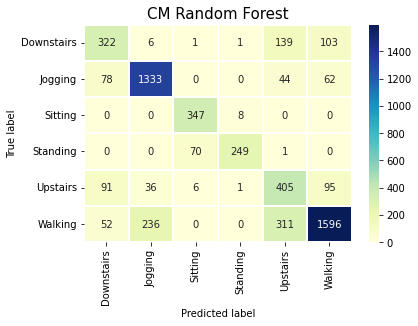

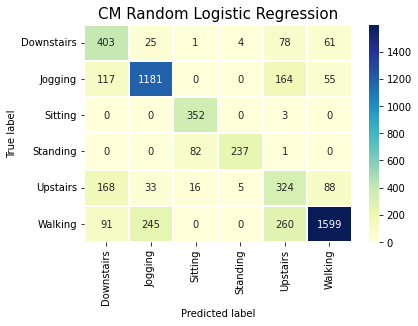

In [128]:
# Create the confusion matrix
cm = confusion_matrix(y_test, y_pred_rf)
labels = ['Downstairs', 'Jogging', 'Sitting', 'Standing', 'Upstairs', 'Walking']
sns.heatmap(cm, xticklabels=labels, yticklabels=labels, annot=True,linewidths = 0.1, fmt='d', cmap = 'YlGnBu')
plt.title('CM Random Forest', fontsize = 15)
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

cm = confusion_matrix(y_test, y_pred_lr)
labels = ['Downstairs', 'Jogging', 'Sitting', 'Standing', 'Upstairs', 'Walking']
sns.heatmap(cm, xticklabels=labels, yticklabels=labels, annot=True,linewidths = 0.1, fmt='d', cmap = 'YlGnBu')
plt.title('CM Random Logistic Regression', fontsize = 15)
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()


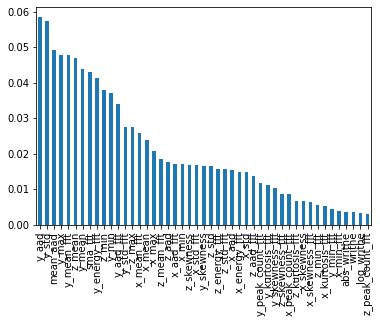

In [129]:
# Create a series containing feature importances from the model and feature names from the training data
feature_importances = pd.Series(rf.feature_importances_, index=X_test.columns).sort_values(ascending=False)

# Plot a simple bar chart
feature_importances.plot.bar();

In [131]:
X_train.columns

Index(['x_mean', 'y_mean', 'z_mean', 'x_std', 'y_std', 'z_std', 'x_aad',
       'y_aad', 'z_aad', 'x_min', 'y_min', 'z_min', 'x_max', 'y_max', 'z_max',
       'x_skewness', 'y_skewness', 'z_skewness', 'writhe', 'x_mean_fft',
       'y_mean_fft', 'z_mean_fft', 'x_std_fft', 'y_std_fft', 'z_std_fft',
       'x_aad_fft', 'y_aad_fft', 'z_aad_fft', 'x_min_fft', 'y_min_fft',
       'z_min_fft', 'x_peak_count_fft', 'y_peak_count_fft', 'z_peak_count_fft',
       'x_skewness_fft', 'y_skewness_fft', 'z_skewness_fft', 'x_kurtosis_fft',
       'y_kurtosis_fft', 'z_kurtosis_fft', 'x_energy_fft', 'y_energy_fft',
       'z_energy_fft', 'sma_fft', 'abs_writhe', 'log_writhe', 'y_train',
       'mean_aad'],
      dtype='object')

## Feature Correlation 

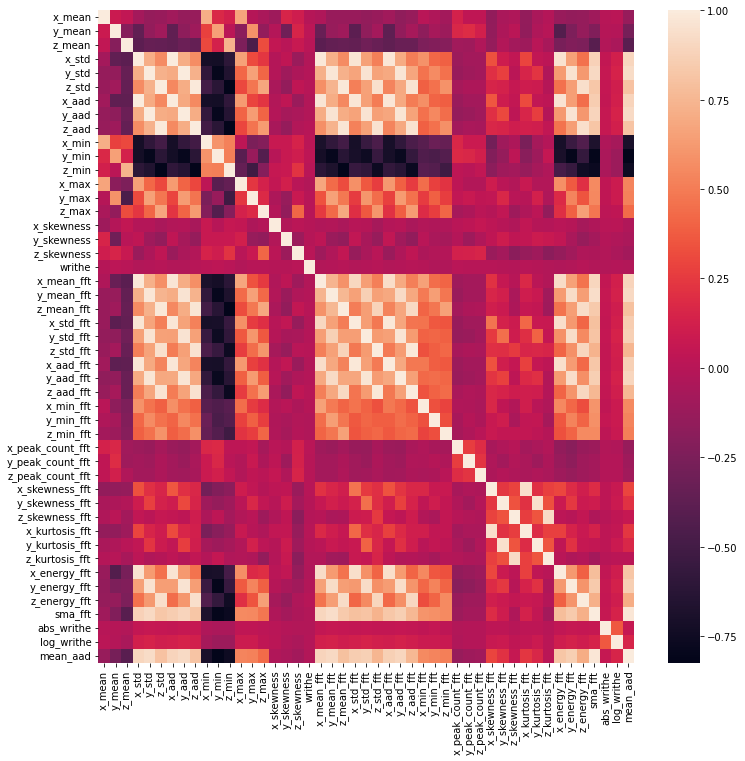

In [135]:
plt.figure(figsize=(12, 12))

corr_m = X_train.drop('y_train',axis=1).corr()
sns.heatmap(corr_m)
plt.show()

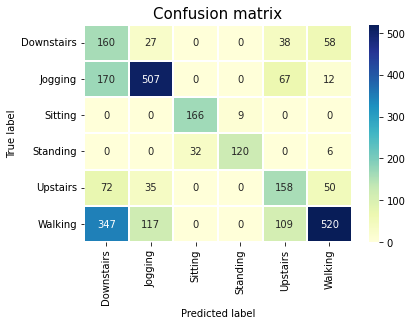

In [53]:
labels = ['Downstairs', 'Jogging', 'Sitting', 'Standing', 'Upstairs', 'Walking']
confusion_matrix = confusion_matrix(y_test, y_pred)
sns.heatmap(confusion_matrix, xticklabels=labels, yticklabels=labels, annot=True,linewidths = 0.1, fmt='d', cmap = 'YlGnBu')
plt.title('Confusion matrix', fontsize = 15)
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

## Writhe features by activity

In [100]:
X_test['writhe']=np.abs(X_test['writhe'])

In [101]:
X_train['log_writhe'] = np.log10(X_train['abs_writhe'])
#X_train['log_writhe_mean'] = np.log10(X_train['writhe_mean'])

In [102]:
X_train['abs_writhe']=np.abs(X_train['writhe'])
#X_train['writhe_mean']=X_train['abs_writhe']*np.abs(X_train['x_max'])

In [103]:
X_train['logmax_writhe']=np.log10(X_train['writhe_max'])

KeyError: 'writhe_max'

In [ ]:
X_train['logmaxwr_mean']=X_train['logmax_writhe']/np.abs(X_train['x_max'])

In [104]:
X_train_y=X_train
X_train_y['y_train']=y_train

In [ ]:
X_train_y.columns

<Axes: title={'center': 'log_writhe'}, xlabel='y_train'>

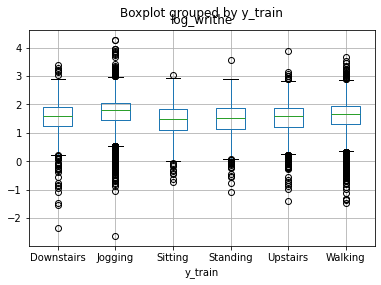

In [105]:
X_train_y.boxplot(column='log_writhe',by='y_train')

<Axes: title={'center': 'abs_writhe'}, xlabel='y_train'>

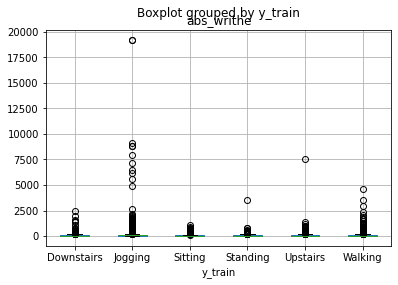

In [106]:
X_train['abs_writhe'] = np.abs(X_train['writhe'])
X_train.boxplot(column='abs_writhe',by='y_train')

KeyError: 'Column not found: writhe_mean'

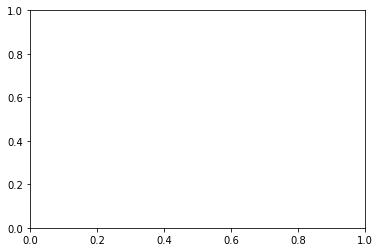

In [107]:
X_train.boxplot(column='writhe_mean',by='y_train')

In [ ]:
X_train.boxplot(column='log_writhe',by='y_train')

<Axes: title={'center': 'writhe'}, xlabel='y_train'>

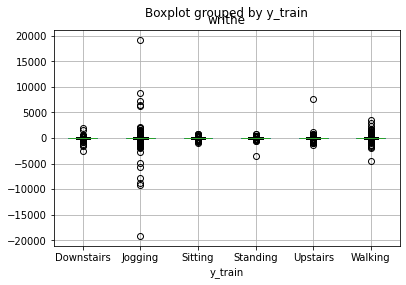

In [108]:
X_train.boxplot(column='writhe',by='y_train')

<Axes: title={'center': 'x_mean'}, xlabel='y_train'>

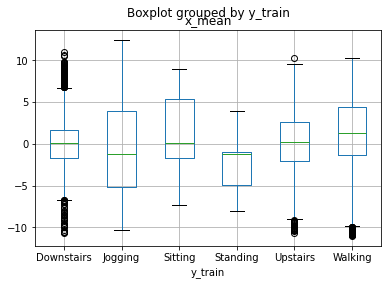

In [109]:
X_train.boxplot(column='x_mean',by='y_train')

## LSTM Version

In [2]:

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

/usr/local/lib/python3.9/site-packages/pandas/core/computation/expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.7.3' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
2025-02-06 13:16:00.880633: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [23]:
x_list.shape

(15790, 25)

In [59]:
XT=np.array(x_list)

In [34]:
from sklearn.preprocessing import LabelBinarizer

lb = LabelBinarizer()
lb.fit(np.array(train_labels))
onehot_trainlb = lb.transform(np.array(train_labels))

In [86]:
len(Xte)

5593

In [104]:
# design network
X=np.array(Xtr)
XT = np.array(Xte)

X = np.reshape(X, (X.shape[0], X.shape[1],  X.shape[2]))
XT = np.reshape(XT, (XT.shape[0],XT.shape[1],  XT.shape[2]))

model = Sequential()
# Build the LSTM model
model = Sequential()
model.add(LSTM(50, input_shape=(X.shape[1], X.shape[2])))
model.add(Dense(6, activation='softmax'))

model.compile(loss='mean_squared_error', optimizer='adam')

# Train the model
model.fit(X, onehot_trainlb, epochs=20, batch_size=20)


Epoch 1/20
790/790 [==============================] - 3s 2ms/step - loss: 0.0712
Epoch 2/20
790/790 [==============================] - 1s 2ms/step - loss: 0.0480
Epoch 3/20
790/790 [==============================] - 1s 2ms/step - loss: 0.0417
Epoch 4/20
790/790 [==============================] - 1s 2ms/step - loss: 0.0379
Epoch 5/20
790/790 [==============================] - 1s 2ms/step - loss: 0.0351
Epoch 6/20
790/790 [==============================] - 1s 2ms/step - loss: 0.0325
Epoch 7/20
790/790 [==============================] - 1s 2ms/step - loss: 0.0301
Epoch 8/20
790/790 [==============================] - 1s 2ms/step - loss: 0.0285
Epoch 9/20
790/790 [==============================] - 1s 2ms/step - loss: 0.0266
Epoch 10/20
790/790 [==============================] - 1s 2ms/step - loss: 0.0253
Epoch 11/20
790/790 [==============================] - 1s 2ms/step - loss: 0.0242
Epoch 12/20
790/790 [==============================] - 1s 2ms/step - loss: 0.0227
Epoch 13/20
790/790 [====

In [105]:
# Make predictions
predictions = model.predict(XT)
print(predictions)


175/175 [==============================] - 0s 983us/step
[[4.0603012e-02 3.5540827e-04 7.6171820e-04 6.2082414e-05 9.5708674e-01
  1.1310433e-03]
 [5.2578568e-01 1.1074193e-04 7.7189616e-04 7.4342836e-04 4.1239157e-01
  6.0196687e-02]
 [6.3601953e-01 2.0603582e-03 5.9049875e-05 9.0883434e-05 2.4218540e-01
  1.1958466e-01]
 ...
 [9.9869235e-04 4.8810915e-09 7.0399693e-03 9.8537987e-01 6.4671924e-03
  1.1414995e-04]
 [7.6162780e-04 3.7812842e-09 5.4239742e-03 9.8948479e-01 4.2629228e-03
  6.6660526e-05]
 [9.2283415e-04 4.3865223e-09 7.4393805e-03 9.8601568e-01 5.5457721e-03
  7.6402132e-05]]


In [106]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
confusion_matrix(lb.inverse_transform(predictions), test_labels)

print(classification_report(lb.inverse_transform(predictions), test_labels))

              precision    recall  f1-score   support

  Downstairs       0.35      0.43      0.39       464
     Jogging       0.91      0.93      0.92      1478
     Sitting       1.00      0.73      0.84       485
    Standing       0.53      0.86      0.66       199
    Upstairs       0.54      0.54      0.54       637
     Walking       0.88      0.83      0.85      2330

    accuracy                           0.78      5593
   macro avg       0.70      0.72      0.70      5593
weighted avg       0.80      0.78      0.79      5593

